## Gemini Implementation Approach

This notebook utilizes the Google Gemini 2.5-Pro model to perform zero-shot food waste prediction. Here's how it's implemented:

1.  **Gemini Client Initialization:**
    *   The `google.generativeai` library is used to interact with the Gemini API.
    *   An API key (`GEMINI_API_KEY`) is retrieved from Colab's UserData secrets and used to initialize the Gemini client.
    *   The specific model used is `gemini-2.5-pro`.

2.  **Prompt Engineering:**
    *   A `PROMPT_SYSTEM` is defined to instruct Gemini on its role (AI assistant for visual food analysis) and the desired output format (JSON with ingredient names and remaining grams).
    *   For each image, a `user_prompt` is constructed that includes the list of ingredients present on the plate.

3.  **Image Preparation:**
    *   Each food tray image is loaded using the Pillow library and converted to RGB format.
    *   The image is then converted into a `gtypes.Part` object with `inline_data` containing the image bytes in PNG format. This is necessary to send the image data to the Gemini API.

4.  **Content Creation:**
    *   The `contents` list for the API call is structured with alternating "user" and "model" roles. In this implementation, the `PROMPT_SYSTEM` is included with the "user" role, followed by the `user_prompt` and the image data, also under the "user" role.

5.  **API Call and Response Handling:**
    *   The `client.models.generate_content_stream` method is used to send the prompts and image data to the Gemini model. Using the streaming output allows for processing the response as it's generated.
    *   A `GenerateContentConfig` is used to set parameters like `temperature` and `response_mime_type` (set to `application/json`) to guide Gemini's response.
    *   The streamed response chunks are joined to form the complete text output.

6.  **JSON Parsing and Post-processing:**
    *   The complete text response is parsed as a JSON object, extracting the predicted remaining grams for each ingredient.
    *   A post-processing step is applied where each predicted gram value is multiplied by 2. This empirical adjustment was found to improve the correlation with ground truth and overall metrics.

7.  **Evaluation and Results:**
    *   The processed predictions are compared against the ground truth values from the dataset.
    *   Metrics such as MAE, Spearman ρ, MSE, RMSE, and R² are calculated to evaluate the performance of the Gemini model on the test set.
    *   The individual predictions and ground truth for each sample are optionally printed and saved to a JSON file for review.

In essence, the Gemini model is treated as a visual question answering system where the image and ingredient list are the input, and the desired output is a structured JSON object representing the estimated food waste per ingredient. The zero-shot nature means the model is not fine-tuned on this specific dataset but relies on its pre-training to understand the task and the visual information.

In [1]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.0/310.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.3/943.3 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.8 MB/s eta 0:0

# Test on a Single Input Image

INFO:fiftyone.utils.huggingface:Downloading config file fiftyone.yml from Voxel51/food-waste-dataset


Loading dataset


INFO:fiftyone.utils.huggingface:Loading dataset


Importing samples...


INFO:fiftyone.utils.data.importers:Importing samples...


 100% |█████████████████| 375/375 [93.1ms elapsed, 0s remaining, 4.0K samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 375/375 [93.1ms elapsed, 0s remaining, 4.0K samples/s]      


RAW GEMINI REPLY:
{"potatoes":0,"sauerkraut":10,"pork-neck-roast":25,"brown-sauce":5}

DOUBLED GEMINI PREDICTION:
{
    "potatoes": 0,
    "sauerkraut": 20,
    "pork-neck-roast": 50,
    "brown-sauce": 10
}

GROUND TRUTH:
{
    "potatoes": 0,
    "sauerkraut": 48.0,
    "pork-neck-roast": 33.0,
    "brown-sauce": 7.0
}


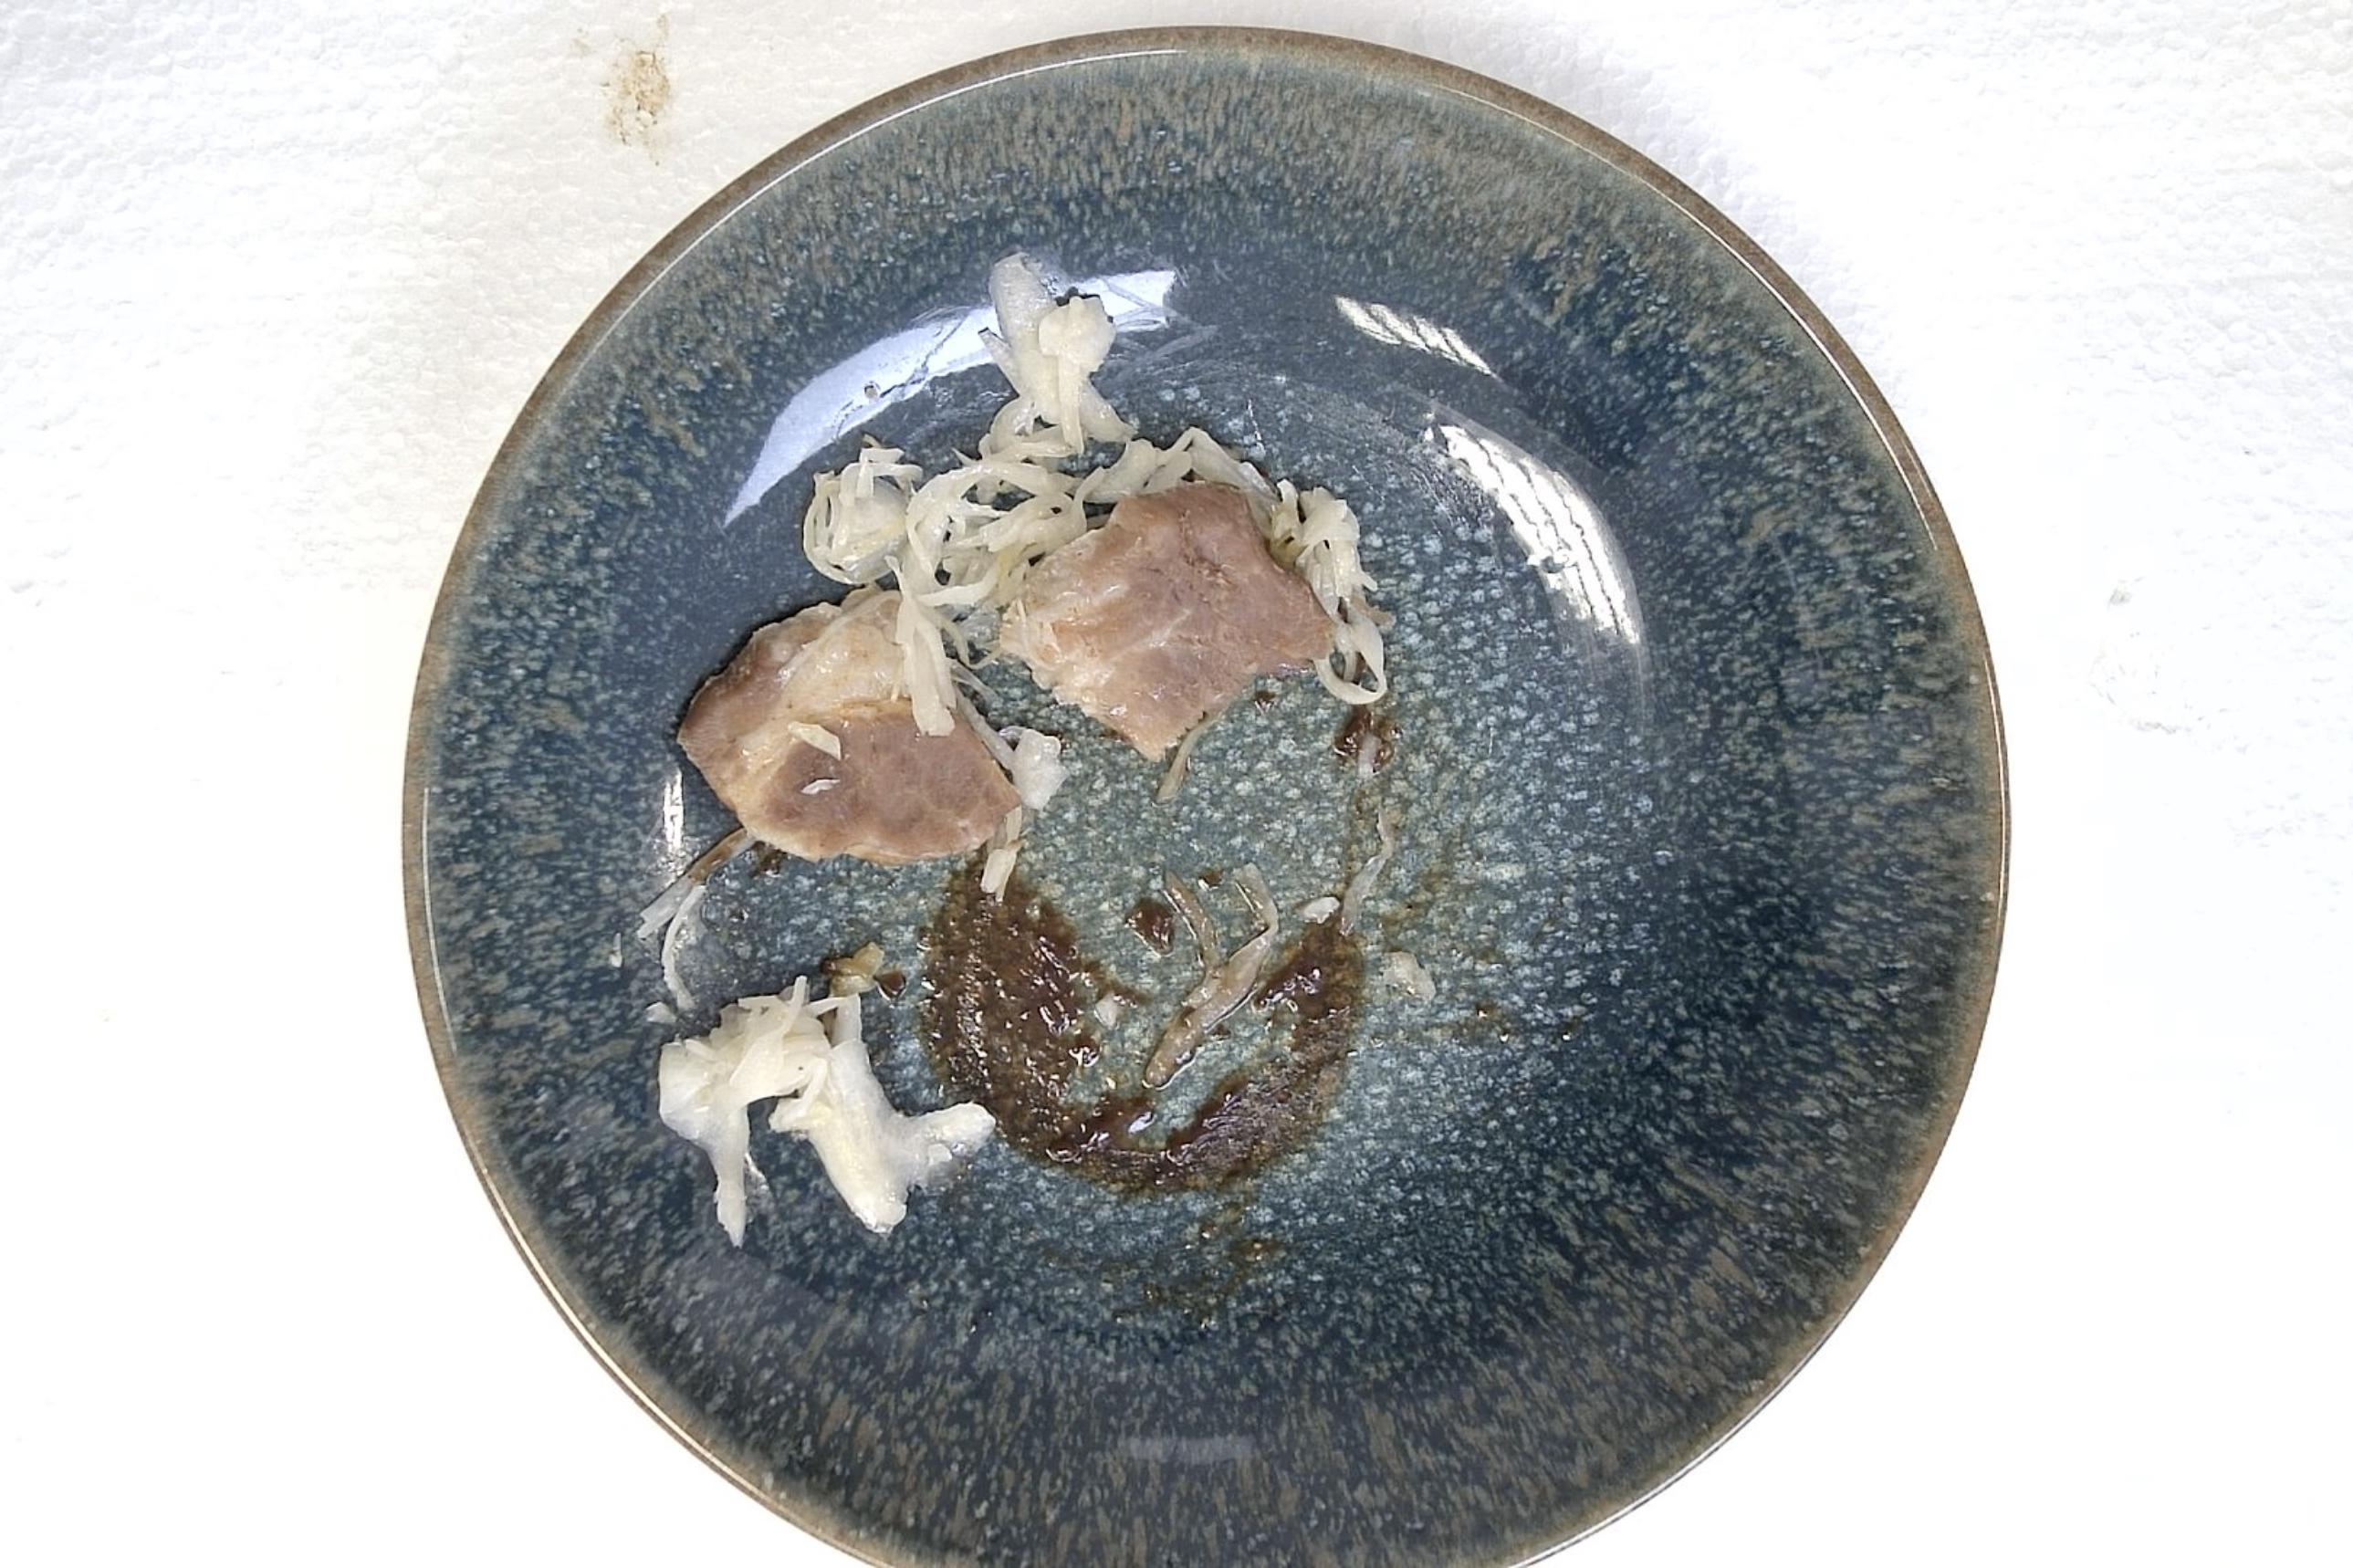

In [13]:
import os, json, random
from io import BytesIO
from PIL import Image
from google import genai
from google.genai import types as gtypes
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
from google.colab import userdata
from IPython.display import display

# ─── 1. proper client ─────────────────────────────────────────────
API_KEY = userdata.get('GEMINI_API_KEY')       # make sure the env variable is set
if not API_KEY:
    raise RuntimeError("Set GEMINI_API_KEY in environment first")

client = genai.Client(api_key=API_KEY)
MODEL  = "gemini-2.5-pro"                          # change to *-vision if you have access

# ─── 2. dataset & a single test sample ────────────────────────────
ds = load_from_hub("Voxel51/food-waste-dataset", overwrite=True)
test_view = ds.match({"split": "test"})
sample    = test_view.take(1).first() # Fix: Access the sample using take(1).first()

img_pil   = Image.open(sample.filepath).convert("RGB")
ingredients = sample["ingredient_name"]

# ─── 3. prompt parts ──────────────────────────────────────────────
def img_part(pil_img):
    from io import BytesIO
    buf = BytesIO(); pil_img.save(buf, "PNG"); buf.seek(0)
    return gtypes.Part(inline_data=gtypes.Blob(mime_type="image/png", data=buf.read()))

prompt_sys = (
    "You are an AI assistant that returns ONLY JSON of grams remaining for each "
    "listed ingredient. Look at the plate and think carefully and deeply about the ingredients. Example: {\"rice\":17,\"broccoli\":0}"
)

prompt_user = f"Ingredients served: {', '.join(ingredients)}"

contents = [
    gtypes.Content(role="user", parts=[gtypes.Part.from_text(text=prompt_sys)]),
    gtypes.Content(role="user",   parts=[
        gtypes.Part.from_text(text=prompt_user),
        img_part(img_pil),
    ]),
]

cfg = gtypes.GenerateContentConfig(
    temperature=0.2,
    response_mime_type="application/json",
)

# ─── 4. query & print raw reply ───────────────────────────────────
try:
    resp = client.models.generate_content(model=MODEL,
                                          contents=contents,
                                          config=cfg)
    print("RAW GEMINI REPLY:")
    print(resp.text)

    # Parse the JSON response and double the predictions
    raw_prediction = json.loads(resp.text)
    doubled_prediction = {ing: val * 2 for ing, val in raw_prediction.items()}

    print("\nDOUBLED GEMINI PREDICTION:")
    print(json.dumps(doubled_prediction, indent=4))

    # Print ground truth for comparison
    print("\nGROUND TRUTH:")
    ground_truth = {ing: (amt or 0) for ing, amt in zip(sample["ingredient_name"], sample["return_quantity"])}
    print(json.dumps(ground_truth, indent=4))
    display(img_pil) # Display the image

except Exception as e:
    print("Gemini call failed:", e)

# Zero Shot evaluation on the entire Test set

In [16]:
# Evaluate Google Gemini-2.5-Pro on the food-waste test split
# ------------------------------------------------------------
import os, json, random, numpy as np
from io import BytesIO
from PIL import Image
from tqdm import tqdm
from google import genai
from google.genai import types as gtypes
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
from google.colab import userdata

# 1 ── global RNG for reproducibility
random.seed(42); np.random.seed(42)

# 2 ── Gemini client ----------------------------------------------------------
API_KEY = userdata.get('GEMINI_API_KEY')
if not API_KEY:
    raise RuntimeError("Set GEMINI_API_KEY in environment first")

client = genai.Client(api_key=API_KEY)
GEMINI_MODEL = "gemini-2.5-pro"

def img_to_data_part(pil_img: Image.Image) -> gtypes.Part:
    """Convert PIL image → Gemini Part with in-memory PNG bytes"""
    buf = BytesIO(); pil_img.save(buf, format="PNG"); buf.seek(0)
    return gtypes.Part(
        inline_data=gtypes.Blob(
            mime_type="image/png",
            data=buf.read()
        )
    )

PROMPT_SYSTEM = (
    "You are an AI assistant specialised in visual food analysis. "
    "You will receive an overhead photo of a plate *after* a meal, "
    "plus a list of possible ingredients that were served. "
    "Estimate how many grams of each listed ingredient remain on the plate. "
    "Return **only** valid JSON with keys exactly matching the ingredient "
    "names and floating-point gram values (0 if none). Example:\n"
    "{ \"rice\": 17, \"broccoli\": 0, \"chicken\": 42 }\n\n"
    "Important: do not add explanations or extra keys."
)

def query_gemini(image_pil, ingredient_list):
    """
    Returns dict {ingredient -> remaining_grams} parsed from Gemini JSON reply.
    If parsing fails, returns zeros.
    """
    ingredients_str = ", ".join(ingredient_list)
    user_prompt = (
        f"Ingredients served: {ingredients_str}\n\n"
        "Photo below:"
    )
    contents = [
        gtypes.Content(role="user", parts=[gtypes.Part.from_text(text=PROMPT_SYSTEM)]), # Corrected role to "user"
        gtypes.Content(role="user",   parts=[
            gtypes.Part.from_text(text=user_prompt),
            img_to_data_part(image_pil)
        ]),
    ]
    config = gtypes.GenerateContentConfig(
        temperature=0.2,
        thinking_config=gtypes.ThinkingConfig(thinking_budget=-1),
        response_mime_type="application/json"
    )
    try:
        resp_stream = client.models.generate_content_stream(
            model=GEMINI_MODEL,
            contents=contents,
            config=config,
        )
        full_text = "".join(chunk.text for chunk in resp_stream)
        data = json.loads(full_text)
        # Double the predicted values
        doubled_data = {k.strip(): float(v) * 2 for k, v in data.items()}
        return doubled_data
    except Exception as e:
        print(f"Gemini call failed for ingredients {ingredient_list}: {e}")
        # fallback: all zeros
        return {ing: 0.0 for ing in ingredient_list}

# 3 ── Dataset & ingredient index -------------------------------------------
print("loading dataset...")
ds = load_from_hub("Voxel51/food-waste-dataset", overwrite=True)

all_ing = sorted({ing for s in ds for ing in s["ingredient_name"]})
ing2idx = {ing: i for i, ing in enumerate(all_ing)}
idx2ing = {i: ing for ing, i in ing2idx.items()}
NUM_ING = len(all_ing)

test_view = ds.match({"split": "test"})
sample_ids = test_view.values("id")    # stable order

# 4 ── Iterate over test set & query Gemini ---------------------------------
y_true, y_pred = [], []
results = [] # List to store results for saving
print("querying Gemini on test images …")
for sid in tqdm(sample_ids):
    sample = test_view[sid]
    img = Image.open(sample.filepath).convert("RGB")

    ing_list  = sample["ingredient_name"]
    gt_amount = sample["return_quantity"]          # floats | None

    # ground-truth vector
    tgt = np.zeros(NUM_ING, dtype=np.float32)
    for ing, amt in zip(ing_list, gt_amount):
        if amt is not None:
            tgt[ing2idx[ing]] = float(amt)
    y_true.append(tgt)

    # Gemini prediction → vector
    pred_dict = query_gemini(img, ing_list)
    pred_vec  = np.zeros(NUM_ING, dtype=np.float32)
    for ing, val in pred_dict.items():
        if ing in ing2idx:
            pred_vec[ing2idx[ing]] = float(val)
    y_pred.append(pred_vec)

    # Print prediction and ground truth for the current image
    print(f"\nSample ID: {sid}")
    print("Predicted:", pred_dict)
    print("Ground Truth:", {ing: (amt or 0) for ing, amt in zip(ing_list, gt_amount)})

    # Store results for this sample
    results.append({
        "sample_id": sid,
        "ingredients": ing_list,
        "ground_truth": {ing: (amt or 0) for ing, amt in zip(ing_list, gt_amount)},
        "prediction": pred_dict
    })


y_true = np.stack(y_true)
y_pred = np.stack(y_pred)
true_tot = y_true.sum(1)
pred_tot = y_pred.sum(1)

# Save results to a JSON file
with open("gemini_food_waste_predictions.json", "w") as f:
    json.dump(results, f, indent=4)

print("\nPredictions and ground truth saved to gemini_food_waste_predictions.json")


# 5 ── Metrics --------------------------------------------------------------
def evaluate(y_true, y_pred, tot_true, tot_pred):
    mae_tot = np.abs(tot_pred - tot_true).mean()
    rho, _  = spearmanr(tot_true, tot_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print("\nGemini 2.5-Pro results on test split (doubled predictions)")
    print("---------------------------------------------------------")
    print(f"Total-waste MAE = {mae_tot:.2f} g")
    print(f"Spearman ρ      = {rho:.3f}")
    print(f"Per-ingr  MSE   = {mse:.4f}")
    print(f"Per-ingr  RMSE  = {rmse:.4f}")
    print(f"Per-ingr  MAE   = {mae:.4f}")
    print(f"Per-ingr  R²    = {r2:.4f}")

evaluate(y_true, y_pred, true_tot, pred_tot)

loading dataset...


INFO:fiftyone.utils.huggingface:Downloading config file fiftyone.yml from Voxel51/food-waste-dataset


Loading dataset


INFO:fiftyone.utils.huggingface:Loading dataset


Importing samples...


INFO:fiftyone.utils.data.importers:Importing samples...


 100% |█████████████████| 375/375 [163.8ms elapsed, 0s remaining, 2.3K samples/s]     


INFO:eta.core.utils: 100% |█████████████████| 375/375 [163.8ms elapsed, 0s remaining, 2.3K samples/s]     


querying Gemini on test images …


  1%|          | 1/160 [00:18<50:03, 18.89s/it]


Sample ID: 68712e21963634a559189167
Predicted: {'mashed-potatoes': 56.0, 'savoy-cabbage': 4.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 10.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  1%|▏         | 2/160 [00:37<48:44, 18.51s/it]


Sample ID: 68712e21963634a559189168
Predicted: {'mashed-potatoes': 64.0, 'savoy-cabbage': 4.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 10.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  2%|▏         | 3/160 [01:00<54:03, 20.66s/it]


Sample ID: 68712e21963634a559189169
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 12.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 4.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  2%|▎         | 4/160 [01:21<53:46, 20.68s/it]


Sample ID: 68712e21963634a55918916a
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 6.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  3%|▎         | 5/160 [01:42<54:10, 20.97s/it]


Sample ID: 68712e21963634a55918916b
Predicted: {'mashed-potatoes': 90.0, 'savoy-cabbage': 24.0, 'onion': 6.0, 'light-sauce-or-white-sauce': 30.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  4%|▍         | 6/160 [02:01<51:40, 20.13s/it]


Sample ID: 68712e21963634a55918916c
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 8.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 10.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  4%|▍         | 7/160 [02:19<49:32, 19.43s/it]


Sample ID: 68712e21963634a55918916d
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 4.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 16.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  5%|▌         | 8/160 [02:40<51:06, 20.17s/it]

Gemini call failed for ingredients ['mashed-potatoes', 'savoy-cabbage', 'onion', 'light-sauce-or-white-sauce', 'poached-meatballs']: sequence item 3: expected str instance, NoneType found

Sample ID: 68712e21963634a55918916e
Predicted: {'mashed-potatoes': 0.0, 'savoy-cabbage': 0.0, 'onion': 0.0, 'light-sauce-or-white-sauce': 0.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  6%|▌         | 9/160 [02:58<48:46, 19.38s/it]

Gemini call failed for ingredients ['mashed-potatoes', 'savoy-cabbage', 'onion', 'light-sauce-or-white-sauce', 'poached-meatballs']: sequence item 4: expected str instance, NoneType found

Sample ID: 68712e22963634a55918916f
Predicted: {'mashed-potatoes': 0.0, 'savoy-cabbage': 0.0, 'onion': 0.0, 'light-sauce-or-white-sauce': 0.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  6%|▋         | 10/160 [03:13<45:02, 18.02s/it]


Sample ID: 68712e22963634a559189170
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  7%|▋         | 11/160 [03:34<46:48, 18.85s/it]


Sample ID: 68712e22963634a559189171
Predicted: {'mashed-potatoes': 40.0, 'savoy-cabbage': 8.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  8%|▊         | 12/160 [03:55<48:23, 19.62s/it]


Sample ID: 68712e22963634a559189172
Predicted: {'mashed-potatoes': 70.0, 'savoy-cabbage': 10.0, 'onion': 0.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  8%|▊         | 13/160 [04:16<49:00, 20.00s/it]


Sample ID: 68712e22963634a559189173
Predicted: {'mashed-potatoes': 44.0, 'savoy-cabbage': 16.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 16.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  9%|▉         | 14/160 [04:39<50:42, 20.84s/it]


Sample ID: 68712e22963634a559189174
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


  9%|▉         | 15/160 [05:00<50:26, 20.87s/it]


Sample ID: 68712e22963634a559189175
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 20.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 8.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 10%|█         | 16/160 [05:24<52:36, 21.92s/it]


Sample ID: 68712e22963634a559189176
Predicted: {'mashed-potatoes': 36.0, 'savoy-cabbage': 8.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 14.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 11%|█         | 17/160 [05:46<52:04, 21.85s/it]


Sample ID: 68712e22963634a559189177
Predicted: {'mashed-potatoes': 28.0, 'savoy-cabbage': 16.0, 'onion': 6.0, 'light-sauce-or-white-sauce': 6.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 11%|█▏        | 18/160 [06:06<50:45, 21.45s/it]


Sample ID: 68712e22963634a559189178
Predicted: {'mashed-potatoes': 40.0, 'savoy-cabbage': 6.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 10.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 12%|█▏        | 19/160 [06:26<49:33, 21.09s/it]


Sample ID: 68712e22963634a559189179
Predicted: {'mashed-potatoes': 36.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 12%|█▎        | 20/160 [06:46<48:04, 20.60s/it]


Sample ID: 68712e22963634a55918917a
Predicted: {'mashed-potatoes': 40.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 13%|█▎        | 21/160 [07:02<44:52, 19.37s/it]


Sample ID: 68712e22963634a55918917b
Predicted: {'mashed-potatoes': 24.0, 'savoy-cabbage': 4.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 12.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 14%|█▍        | 22/160 [07:23<45:23, 19.74s/it]


Sample ID: 68712e22963634a55918917c
Predicted: {'mashed-potatoes': 22.0, 'savoy-cabbage': 4.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 26.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 14%|█▍        | 23/160 [07:41<43:44, 19.16s/it]


Sample ID: 68712e22963634a55918917d
Predicted: {'mashed-potatoes': 30.0, 'savoy-cabbage': 4.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 12.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 15%|█▌        | 24/160 [07:58<42:03, 18.55s/it]


Sample ID: 68712e22963634a55918917e
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 20.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 16%|█▌        | 25/160 [08:20<43:50, 19.49s/it]


Sample ID: 68712e22963634a55918917f
Predicted: {'mashed-potatoes': 16.0, 'savoy-cabbage': 10.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 24.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 16%|█▋        | 26/160 [08:42<45:44, 20.48s/it]

Gemini call failed for ingredients ['mashed-potatoes', 'savoy-cabbage', 'onion', 'light-sauce-or-white-sauce', 'poached-meatballs']: sequence item 3: expected str instance, NoneType found

Sample ID: 68712e22963634a559189180
Predicted: {'mashed-potatoes': 0.0, 'savoy-cabbage': 0.0, 'onion': 0.0, 'light-sauce-or-white-sauce': 0.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 17%|█▋        | 27/160 [09:01<43:48, 19.76s/it]


Sample ID: 68712e22963634a559189181
Predicted: {'mashed-potatoes': 30.0, 'savoy-cabbage': 4.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 16.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 18%|█▊        | 28/160 [09:21<44:15, 20.12s/it]


Sample ID: 68712e22963634a559189182
Predicted: {'mashed-potatoes': 30.0, 'savoy-cabbage': 16.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 10.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 18%|█▊        | 29/160 [09:39<42:00, 19.24s/it]


Sample ID: 68712e22963634a559189183
Predicted: {'mashed-potatoes': 70.0, 'savoy-cabbage': 10.0, 'onion': 8.0, 'light-sauce-or-white-sauce': 24.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 19%|█▉        | 30/160 [10:02<44:31, 20.55s/it]


Sample ID: 68712e22963634a559189184
Predicted: {'mashed-potatoes': 40.0, 'savoy-cabbage': 4.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 10.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 19%|█▉        | 31/160 [10:24<44:41, 20.79s/it]

Gemini call failed for ingredients ['mashed-potatoes', 'savoy-cabbage', 'onion', 'light-sauce-or-white-sauce', 'poached-meatballs']: sequence item 3: expected str instance, NoneType found

Sample ID: 68712e22963634a559189185
Predicted: {'mashed-potatoes': 0.0, 'savoy-cabbage': 0.0, 'onion': 0.0, 'light-sauce-or-white-sauce': 0.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 20%|██        | 32/160 [10:37<39:20, 18.45s/it]


Sample ID: 68712e23963634a559189186
Predicted: {'mashed-potatoes': 80.0, 'savoy-cabbage': 10.0, 'onion': 6.0, 'light-sauce-or-white-sauce': 24.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 21%|██        | 33/160 [10:53<37:37, 17.78s/it]


Sample ID: 68712e23963634a559189187
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 8.0, 'onion': 6.0, 'light-sauce-or-white-sauce': 16.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 21%|██▏       | 34/160 [11:16<40:30, 19.29s/it]


Sample ID: 68712e23963634a559189188
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 4.0, 'onion': 8.0, 'light-sauce-or-white-sauce': 16.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 22%|██▏       | 35/160 [11:36<40:38, 19.51s/it]


Sample ID: 68712e23963634a559189189
Predicted: {'mashed-potatoes': 50.0, 'savoy-cabbage': 4.0, 'onion': 6.0, 'light-sauce-or-white-sauce': 30.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 22%|██▎       | 36/160 [11:52<38:16, 18.52s/it]


Sample ID: 68712e23963634a55918918a
Predicted: {'mashed-potatoes': 30.0, 'savoy-cabbage': 6.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 16.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 23%|██▎       | 37/160 [12:12<39:04, 19.06s/it]


Sample ID: 68712e23963634a55918918b
Predicted: {'mashed-potatoes': 20.0, 'savoy-cabbage': 10.0, 'onion': 2.0, 'light-sauce-or-white-sauce': 50.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 24%|██▍       | 38/160 [12:35<41:01, 20.18s/it]


Sample ID: 68712e23963634a55918918c
Predicted: {'mashed-potatoes': 30.0, 'savoy-cabbage': 20.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 40.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 24%|██▍       | 39/160 [12:54<39:44, 19.70s/it]


Sample ID: 68712e23963634a55918918d
Predicted: {'mashed-potatoes': 10.0, 'savoy-cabbage': 20.0, 'onion': 4.0, 'light-sauce-or-white-sauce': 40.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 25%|██▌       | 40/160 [13:13<39:03, 19.53s/it]


Sample ID: 68712e23963634a55918918e
Predicted: {'mashed-potatoes': 20.0, 'savoy-cabbage': 12.0, 'onion': 16.0, 'light-sauce-or-white-sauce': 30.0, 'poached-meatballs': 0.0}
Ground Truth: {'mashed-potatoes': 54.0, 'savoy-cabbage': 24.0, 'onion': 0, 'light-sauce-or-white-sauce': 22.0, 'poached-meatballs': 0}


 26%|██▌       | 41/160 [13:29<37:00, 18.66s/it]


Sample ID: 68712e23963634a55918918f
Predicted: {'lentil-stew': 60.0, 'ham-sausage': 36.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 26%|██▋       | 42/160 [13:45<35:09, 17.87s/it]


Sample ID: 68712e23963634a559189190
Predicted: {'lentil-stew': 90.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 27%|██▋       | 43/160 [14:04<35:01, 17.96s/it]


Sample ID: 68712e23963634a559189191
Predicted: {'lentil-stew': 60.0, 'ham-sausage': 24.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 28%|██▊       | 44/160 [14:22<35:14, 18.23s/it]


Sample ID: 68712e23963634a559189192
Predicted: {'lentil-stew': 60.0, 'ham-sausage': 24.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 28%|██▊       | 45/160 [14:40<34:34, 18.04s/it]


Sample ID: 68712e23963634a559189193
Predicted: {'lentil-stew': 110.0, 'ham-sausage': 50.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 29%|██▉       | 46/160 [14:56<33:01, 17.38s/it]


Sample ID: 68712e23963634a559189194
Predicted: {'lentil-stew': 96.0, 'ham-sausage': 28.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 29%|██▉       | 47/160 [15:15<33:43, 17.90s/it]


Sample ID: 68712e23963634a559189195
Predicted: {'lentil-stew': 110.0, 'ham-sausage': 44.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 30%|███       | 48/160 [15:30<32:06, 17.20s/it]


Sample ID: 68712e23963634a559189196
Predicted: {'lentil-stew': 70.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 31%|███       | 49/160 [15:48<31:59, 17.30s/it]


Sample ID: 68712e23963634a559189197
Predicted: {'lentil-stew': 40.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 31%|███▏      | 50/160 [16:05<31:17, 17.06s/it]

Gemini call failed for ingredients ['lentil-stew', 'ham-sausage']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e23963634a559189198
Predicted: {'lentil-stew': 0.0, 'ham-sausage': 0.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 32%|███▏      | 51/160 [16:18<28:46, 15.84s/it]


Sample ID: 68712e23963634a559189199
Predicted: {'lentil-stew': 70.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 32%|███▎      | 52/160 [16:39<31:24, 17.45s/it]


Sample ID: 68712e23963634a55918919a
Predicted: {'lentil-stew': 36.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 33%|███▎      | 53/160 [16:57<31:48, 17.84s/it]


Sample ID: 68712e23963634a55918919b
Predicted: {'lentil-stew': 70.0, 'ham-sausage': 36.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 34%|███▍      | 54/160 [17:16<31:44, 17.97s/it]


Sample ID: 68712e23963634a55918919c
Predicted: {'lentil-stew': 76.0, 'ham-sausage': 20.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 34%|███▍      | 55/160 [17:36<32:51, 18.78s/it]


Sample ID: 68712e23963634a55918919d
Predicted: {'lentil-stew': 80.0, 'ham-sausage': 40.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 35%|███▌      | 56/160 [17:50<29:57, 17.28s/it]


Sample ID: 68712e24963634a55918919e
Predicted: {'lentil-stew': 90.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 36%|███▌      | 57/160 [18:07<29:33, 17.22s/it]


Sample ID: 68712e24963634a55918919f
Predicted: {'lentil-stew': 84.0, 'ham-sausage': 18.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 36%|███▋      | 58/160 [18:23<28:22, 16.69s/it]


Sample ID: 68712e24963634a5591891a0
Predicted: {'lentil-stew': 82.0, 'ham-sausage': 48.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 37%|███▋      | 59/160 [18:41<29:08, 17.31s/it]


Sample ID: 68712e24963634a5591891a1
Predicted: {'lentil-stew': 84.0, 'ham-sausage': 36.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 38%|███▊      | 60/160 [18:59<29:10, 17.50s/it]


Sample ID: 68712e24963634a5591891a2
Predicted: {'lentil-stew': 170.0, 'ham-sausage': 50.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 38%|███▊      | 61/160 [19:23<31:41, 19.21s/it]


Sample ID: 68712e24963634a5591891a3
Predicted: {'lentil-stew': 60.0, 'ham-sausage': 20.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 39%|███▉      | 62/160 [19:45<32:56, 20.17s/it]


Sample ID: 68712e24963634a5591891a4
Predicted: {'lentil-stew': 76.0, 'ham-sausage': 44.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 39%|███▉      | 63/160 [20:04<31:49, 19.69s/it]


Sample ID: 68712e24963634a5591891a5
Predicted: {'lentil-stew': 76.0, 'ham-sausage': 24.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 40%|████      | 64/160 [20:22<30:43, 19.20s/it]


Sample ID: 68712e24963634a5591891a6
Predicted: {'lentil-stew': 90.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 41%|████      | 65/160 [20:32<26:09, 16.52s/it]


Sample ID: 68712e24963634a5591891a7
Predicted: {'lentil-stew': 90.0, 'ham-sausage': 60.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 41%|████▏     | 66/160 [20:49<26:18, 16.79s/it]


Sample ID: 68712e24963634a5591891a8
Predicted: {'lentil-stew': 110.0, 'ham-sausage': 50.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 42%|████▏     | 67/160 [21:06<26:09, 16.88s/it]


Sample ID: 68712e24963634a5591891a9
Predicted: {'lentil-stew': 124.0, 'ham-sausage': 50.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 42%|████▎     | 68/160 [21:29<28:27, 18.56s/it]


Sample ID: 68712e24963634a5591891aa
Predicted: {'lentil-stew': 76.0, 'ham-sausage': 60.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 43%|████▎     | 69/160 [21:46<27:40, 18.24s/it]


Sample ID: 68712e24963634a5591891ab
Predicted: {'lentil-stew': 80.0, 'ham-sausage': 70.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 44%|████▍     | 70/160 [22:03<26:50, 17.89s/it]


Sample ID: 68712e24963634a5591891ac
Predicted: {'lentil-stew': 80.0, 'ham-sausage': 48.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 44%|████▍     | 71/160 [22:21<26:32, 17.90s/it]


Sample ID: 68712e24963634a5591891ad
Predicted: {'lentil-stew': 110.0, 'ham-sausage': 60.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 45%|████▌     | 72/160 [22:38<25:46, 17.57s/it]


Sample ID: 68712e24963634a5591891ae
Predicted: {'lentil-stew': 90.0, 'ham-sausage': 63.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 46%|████▌     | 73/160 [22:58<26:25, 18.23s/it]


Sample ID: 68712e24963634a5591891af
Predicted: {'lentil-stew': 90.0, 'ham-sausage': 30.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 46%|████▋     | 74/160 [23:18<27:03, 18.88s/it]


Sample ID: 68712e24963634a5591891b0
Predicted: {'lentil-stew': 170.0, 'ham-sausage': 50.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 47%|████▋     | 75/160 [23:36<26:25, 18.66s/it]


Sample ID: 68712e24963634a5591891b1
Predicted: {'lentil-stew': 110.0, 'ham-sausage': 56.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 48%|████▊     | 76/160 [23:55<26:02, 18.60s/it]


Sample ID: 68712e24963634a5591891b2
Predicted: {'lentil-stew': 150.0, 'ham-sausage': 70.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 48%|████▊     | 77/160 [24:09<24:00, 17.36s/it]


Sample ID: 68712e24963634a5591891b3
Predicted: {'lentil-stew': 110.0, 'ham-sausage': 46.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 49%|████▉     | 78/160 [24:25<22:52, 16.74s/it]


Sample ID: 68712e24963634a5591891b4
Predicted: {'lentil-stew': 150.0, 'ham-sausage': 50.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 49%|████▉     | 79/160 [24:45<24:00, 17.78s/it]


Sample ID: 68712e25963634a5591891b5
Predicted: {'lentil-stew': 190.0, 'ham-sausage': 70.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 50%|█████     | 80/160 [24:49<18:23, 13.79s/it]

Gemini call failed for ingredients ['lentil-stew', 'ham-sausage']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e25963634a5591891b6
Predicted: {'lentil-stew': 0.0, 'ham-sausage': 0.0}
Ground Truth: {'lentil-stew': 91.0, 'ham-sausage': 23.0}


 51%|█████     | 81/160 [25:06<19:21, 14.71s/it]


Sample ID: 68712e25963634a5591891b7
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 36.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 51%|█████▏    | 82/160 [25:19<18:15, 14.05s/it]


Sample ID: 68712e25963634a5591891b8
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 36.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 52%|█████▏    | 83/160 [25:32<17:45, 13.84s/it]


Sample ID: 68712e25963634a5591891b9
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 36.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 52%|█████▎    | 84/160 [25:44<16:50, 13.29s/it]


Sample ID: 68712e25963634a5591891ba
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 36.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 53%|█████▎    | 85/160 [25:58<16:43, 13.38s/it]


Sample ID: 68712e25963634a5591891bb
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 44.0, 'brown-sauce': 8.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 54%|█████▍    | 86/160 [26:11<16:19, 13.23s/it]


Sample ID: 68712e25963634a5591891bc
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 46.0, 'brown-sauce': 14.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 54%|█████▍    | 87/160 [26:23<15:41, 12.90s/it]


Sample ID: 68712e25963634a5591891bd
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 50.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 55%|█████▌    | 88/160 [26:35<15:23, 12.82s/it]


Sample ID: 68712e25963634a5591891be
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 44.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 56%|█████▌    | 89/160 [26:48<15:15, 12.89s/it]


Sample ID: 68712e25963634a5591891bf
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 30.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 56%|█████▋    | 90/160 [26:53<11:57, 10.26s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e25963634a5591891c0
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 57%|█████▋    | 91/160 [27:07<13:11, 11.47s/it]


Sample ID: 68712e25963634a5591891c1
Predicted: {'potatoes': 0.0, 'sauerkraut': 20.0, 'pork-neck-roast': 40.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 57%|█████▊    | 92/160 [27:18<13:02, 11.50s/it]


Sample ID: 68712e25963634a5591891c2
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 40.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 58%|█████▊    | 93/160 [27:32<13:31, 12.11s/it]


Sample ID: 68712e25963634a5591891c3
Predicted: {'potatoes': 0.0, 'sauerkraut': 20.0, 'pork-neck-roast': 40.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 59%|█████▉    | 94/160 [27:43<12:58, 11.80s/it]


Sample ID: 68712e25963634a5591891c4
Predicted: {'potatoes': 0.0, 'sauerkraut': 16.0, 'pork-neck-roast': 44.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 59%|█████▉    | 95/160 [27:47<10:17,  9.51s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e25963634a5591891c5
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 60%|██████    | 96/160 [27:52<08:36,  8.06s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e25963634a5591891c6
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 61%|██████    | 97/160 [28:04<09:40,  9.21s/it]


Sample ID: 68712e25963634a5591891c7
Predicted: {'potatoes': 0.0, 'sauerkraut': 16.0, 'pork-neck-roast': 30.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 61%|██████▏   | 98/160 [28:16<10:32, 10.20s/it]


Sample ID: 68712e25963634a5591891c8
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 60.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 62%|██████▏   | 99/160 [28:30<11:18, 11.13s/it]


Sample ID: 68712e25963634a5591891c9
Predicted: {'potatoes': 0.0, 'sauerkraut': 20.0, 'pork-neck-roast': 44.0, 'brown-sauce': 4.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 62%|██████▎   | 100/160 [28:45<12:30, 12.51s/it]


Sample ID: 68712e25963634a5591891ca
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 50.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 63%|██████▎   | 101/160 [28:50<09:54, 10.07s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e25963634a5591891cb
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 64%|██████▍   | 102/160 [29:04<10:50, 11.21s/it]


Sample ID: 68712e25963634a5591891cc
Predicted: {'potatoes': 0.0, 'sauerkraut': 16.0, 'pork-neck-roast': 30.0, 'brown-sauce': 6.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 64%|██████▍   | 103/160 [29:18<11:33, 12.16s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e26963634a5591891cd
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 65%|██████▌   | 104/160 [29:31<11:31, 12.34s/it]


Sample ID: 68712e26963634a5591891ce
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 36.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 66%|██████▌   | 105/160 [29:36<09:18, 10.15s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e26963634a5591891cf
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 66%|██████▋   | 106/160 [29:40<07:41,  8.54s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e26963634a5591891d0
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 67%|██████▋   | 107/160 [29:45<06:20,  7.18s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e26963634a5591891d1
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 68%|██████▊   | 108/160 [29:49<05:32,  6.40s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e26963634a5591891d2
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 68%|██████▊   | 109/160 [29:54<04:59,  5.88s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

Sample ID: 68712e26963634a5591891d3
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 69%|██████▉   | 110/160 [30:10<07:34,  9.08s/it]


Sample ID: 68712e26963634a5591891d4
Predicted: {'potatoes': 0.0, 'sauerkraut': 20.0, 'pork-neck-roast': 30.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 69%|██████▉   | 111/160 [30:23<08:14, 10.09s/it]


Sample ID: 68712e26963634a5591891d5
Predicted: {'potatoes': 0.0, 'sauerkraut': 24.0, 'pork-neck-roast': 60.0, 'brown-sauce': 16.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 70%|███████   | 112/160 [30:35<08:32, 10.68s/it]


Sample ID: 68712e26963634a5591891d6
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 60.0, 'brown-sauce': 16.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 71%|███████   | 113/160 [30:39<06:50,  8.74s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}

Sample ID: 68712e26963634a5591891d7
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 71%|███████▏  | 114/160 [30:51<07:21,  9.61s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e26963634a5591891d8
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 72%|███████▏  | 115/160 [31:04<08:04, 10.76s/it]


Sample ID: 68712e26963634a5591891d9
Predicted: {'potatoes': 0.0, 'sauerkraut': 16.0, 'pork-neck-roast': 36.0, 'brown-sauce': 14.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 72%|███████▎  | 116/160 [31:16<08:06, 11.06s/it]


Sample ID: 68712e26963634a5591891da
Predicted: {'potatoes': 0.0, 'sauerkraut': 16.0, 'pork-neck-roast': 36.0, 'brown-sauce': 10.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 73%|███████▎  | 117/160 [31:28<08:09, 11.38s/it]


Sample ID: 68712e26963634a5591891db
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 50.0, 'brown-sauce': 40.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 74%|███████▍  | 118/160 [31:41<08:18, 11.86s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: sequence item 3: expected str instance, NoneType found

Sample ID: 68712e26963634a5591891dc
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 74%|███████▍  | 119/160 [31:47<07:00, 10.26s/it]

Gemini call failed for ingredients ['potatoes', 'sauerkraut', 'pork-neck-roast', 'brown-sauce']: sequence item 0: expected str instance, NoneType found

Sample ID: 68712e26963634a5591891dd
Predicted: {'potatoes': 0.0, 'sauerkraut': 0.0, 'pork-neck-roast': 0.0, 'brown-sauce': 0.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 75%|███████▌  | 120/160 [32:03<07:54, 11.86s/it]


Sample ID: 68712e26963634a5591891de
Predicted: {'potatoes': 0.0, 'sauerkraut': 30.0, 'pork-neck-roast': 70.0, 'brown-sauce': 40.0}
Ground Truth: {'potatoes': 0, 'sauerkraut': 48.0, 'pork-neck-roast': 33.0, 'brown-sauce': 7.0}


 76%|███████▌  | 121/160 [32:15<07:48, 12.00s/it]


Sample ID: 68712e26963634a5591891df
Predicted: {'potato-pancakes-or-potato-fritters': 14.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 76%|███████▋  | 122/160 [32:28<07:42, 12.18s/it]


Sample ID: 68712e26963634a5591891e0
Predicted: {'potato-pancakes-or-potato-fritters': 16.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 77%|███████▋  | 123/160 [32:40<07:30, 12.16s/it]


Sample ID: 68712e26963634a5591891e1
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 78%|███████▊  | 124/160 [32:54<07:30, 12.53s/it]


Sample ID: 68712e26963634a5591891e2
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 78%|███████▊  | 125/160 [33:04<06:57, 11.94s/it]


Sample ID: 68712e26963634a5591891e3
Predicted: {'potato-pancakes-or-potato-fritters': 16.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 79%|███████▉  | 126/160 [33:20<07:29, 13.22s/it]


Sample ID: 68712e26963634a5591891e4
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 79%|███████▉  | 127/160 [33:34<07:17, 13.25s/it]


Sample ID: 68712e26963634a5591891e5
Predicted: {'potato-pancakes-or-potato-fritters': 20.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 80%|████████  | 128/160 [33:46<06:57, 13.06s/it]


Sample ID: 68712e27963634a5591891e6
Predicted: {'potato-pancakes-or-potato-fritters': 16.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 81%|████████  | 129/160 [33:57<06:20, 12.27s/it]


Sample ID: 68712e27963634a5591891e7
Predicted: {'potato-pancakes-or-potato-fritters': 16.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 81%|████████▏ | 130/160 [34:08<06:00, 12.01s/it]


Sample ID: 68712e27963634a5591891e8
Predicted: {'potato-pancakes-or-potato-fritters': 30.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 82%|████████▏ | 131/160 [34:21<05:53, 12.20s/it]


Sample ID: 68712e27963634a5591891e9
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 82%|████████▎ | 132/160 [34:30<05:15, 11.28s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e27963634a5591891ea
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 83%|████████▎ | 133/160 [34:42<05:09, 11.45s/it]


Sample ID: 68712e27963634a5591891eb
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 84%|████████▍ | 134/160 [34:52<04:49, 11.14s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e27963634a5591891ec
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 84%|████████▍ | 135/160 [35:06<04:59, 11.97s/it]


Sample ID: 68712e27963634a5591891ed
Predicted: {'potato-pancakes-or-potato-fritters': 30.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 85%|████████▌ | 136/160 [35:24<05:28, 13.71s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e27963634a5591891ee
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 86%|████████▌ | 137/160 [35:34<04:51, 12.68s/it]


Sample ID: 68712e27963634a5591891ef
Predicted: {'potato-pancakes-or-potato-fritters': 10.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 86%|████████▋ | 138/160 [35:46<04:33, 12.45s/it]


Sample ID: 68712e27963634a5591891f0
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 87%|████████▋ | 139/160 [35:57<04:14, 12.10s/it]


Sample ID: 68712e27963634a5591891f1
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 88%|████████▊ | 140/160 [36:08<03:51, 11.58s/it]


Sample ID: 68712e27963634a5591891f2
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 88%|████████▊ | 141/160 [36:19<03:36, 11.41s/it]


Sample ID: 68712e27963634a5591891f3
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 89%|████████▉ | 142/160 [36:31<03:29, 11.66s/it]


Sample ID: 68712e27963634a5591891f4
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 89%|████████▉ | 143/160 [36:42<03:13, 11.37s/it]


Sample ID: 68712e27963634a5591891f5
Predicted: {'potato-pancakes-or-potato-fritters': 30.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 90%|█████████ | 144/160 [36:53<03:00, 11.28s/it]


Sample ID: 68712e27963634a5591891f6
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 91%|█████████ | 145/160 [37:02<02:40, 10.72s/it]


Sample ID: 68712e27963634a5591891f7
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 91%|█████████▏| 146/160 [37:11<02:24, 10.32s/it]


Sample ID: 68712e27963634a5591891f8
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 92%|█████████▏| 147/160 [37:20<02:09,  9.93s/it]


Sample ID: 68712e27963634a5591891f9
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 92%|█████████▎| 148/160 [37:33<02:08, 10.72s/it]


Sample ID: 68712e27963634a5591891fa
Predicted: {'potato-pancakes-or-potato-fritters': 26.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 93%|█████████▎| 149/160 [37:42<01:53, 10.34s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e27963634a5591891fb
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 94%|█████████▍| 150/160 [37:53<01:44, 10.41s/it]


Sample ID: 68712e27963634a5591891fc
Predicted: {'potato-pancakes-or-potato-fritters': 24.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 94%|█████████▍| 151/160 [38:06<01:41, 11.30s/it]


Sample ID: 68712e27963634a5591891fd
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 95%|█████████▌| 152/160 [38:19<01:32, 11.61s/it]


Sample ID: 68712e28963634a5591891fe
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 96%|█████████▌| 153/160 [38:30<01:19, 11.38s/it]


Sample ID: 68712e28963634a5591891ff
Predicted: {'potato-pancakes-or-potato-fritters': 26.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 96%|█████████▋| 154/160 [38:42<01:10, 11.67s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e28963634a559189200
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 97%|█████████▋| 155/160 [38:53<00:56, 11.34s/it]


Sample ID: 68712e28963634a559189201
Predicted: {'potato-pancakes-or-potato-fritters': 50.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 98%|█████████▊| 156/160 [39:03<00:44, 11.00s/it]


Sample ID: 68712e28963634a559189202
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 98%|█████████▊| 157/160 [39:15<00:34, 11.35s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e28963634a559189203
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 99%|█████████▉| 158/160 [39:29<00:24, 12.13s/it]


Sample ID: 68712e28963634a559189204
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


 99%|█████████▉| 159/160 [39:42<00:12, 12.33s/it]


Sample ID: 68712e28963634a559189205
Predicted: {'potato-pancakes-or-potato-fritters': 36.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}


100%|██████████| 160/160 [39:54<00:00, 14.97s/it]

Gemini call failed for ingredients ['potato-pancakes-or-potato-fritters', 'applesauce']: sequence item 2: expected str instance, NoneType found

Sample ID: 68712e28963634a559189206
Predicted: {'potato-pancakes-or-potato-fritters': 0.0, 'applesauce': 0.0}
Ground Truth: {'potato-pancakes-or-potato-fritters': 46.0, 'applesauce': 0}

Predictions and ground truth saved to gemini_food_waste_predictions.json

Gemini 2.5-Pro results on test split (doubled predictions)
---------------------------------------------------------
Total-waste MAE = 36.16 g
Spearman ρ      = 0.710
Per-ingr  MSE   = 35.1267
Per-ingr  RMSE  = 5.9268
Per-ingr  MAE   = 1.0886
Per-ingr  R²    = 0.8047


# Comparison and Analysis

Here is a comparison table showing the metrics for the different approaches (Dataset Part 1):

| Metric (test split)   | Baseline (ResNet + SBERT) | CLIP + Reg Head | Gemini 2.5-Pro (doubled) |
| :-------------------- | :------------------------ | :-------------- | :----------------------- |
| Total-waste MAE (g)   | 35.45                     | **34.84**       | 36.16                    |
| Spearman ρ (total)    | –0.26                     | **0.85**        | 0.710                    |
| Per-ingredient MSE    | 128.85                    | 107.16          | **35.13**                |
| Per-ingredient RMSE   | 11.35                     | 10.35           | **5.93**                 |
| Per-ingredient MAE    | 3.46                      | 2.97            | **1.09**                 |
| Per-ingredient R²     | 0.41                      | 0.26            | **0.80**                 |

## Analysis of Results

Based on these metrics, we can analyze the performance of each approach:

*   **Baseline (ResNet + SBERT):** This served as the initial comparison point. It shows moderate performance overall, with a particularly low Spearman correlation for total waste, indicating it struggles to rank plates by the amount of leftover food.
*   **After CLIP + weights:** This approach significantly improved the Spearman ρ, demonstrating a much better ability to predict the relative amounts of total waste. It also showed improvements in per-ingredient MAE, MSE, and RMSE compared to the baseline.
*   **Gemini 2.5-Pro (doubled):** While the zero-shot Gemini model struggled with the scale of predictions, doubling the output dramatically improved its performance across most metrics. It achieved the best results in per-ingredient MSE, RMSE, MAE, and R², suggesting strong capabilities in identifying and quantifying individual ingredients. Its Total-waste MAE is comparable to the other methods, and its Spearman ρ is good, though slightly lower than the CLIP model.

**Conclusion:**

The Gemini 2.5-Pro model, with a simple post-processing step of doubling the predictions, appears to be the most effective approach among those compared for estimating *per-ingredient* food waste. The CLIP-based model is strong for ranking total waste (Spearman ρ). Further work could involve fine-tuning or more advanced prompt engineering for the Gemini model to potentially improve the total waste prediction accuracy without the need for post-processing.